In [1]:
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.stats import expon

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (plot_confusion_matrix,
                             classification_report,
                             roc_curve,
                             f1_score,
                             balanced_accuracy_score,
                             brier_score_loss,
                             precision_recall_fscore_support,
                             zero_one_loss)

In [2]:
def get_data(tablename):
    '''
    input desired table name as a string
    returns table as pandas data frame
    '''
    df = pd.read_csv(f'../data/ga_archive/{tablename}', sep = '|')
    return df

In [3]:
def clean_data(df):
    vmask = df['date_last_voted'] >= '2020-11-03'
    df['voted'] = vmask.map({True: int(1), False: int(0)})
    
    df = df.drop(['land_district','land_lot','status_reason','city_precinct_id','county_districta_name',
                'county_districta_value','county_districtb_name','county_districtb_value','city_dista_name',
                'city_dista_value','city_distb_name','city_distb_value','city_distc_name','city_distc_value',
                'city_distd_name','city_distd_value','party_last_voted','city_school_district_name','municipal_name',
                'municipal_code','ward_city_council_code','race_desc','residence_city','residence_zipcode',
                'county_precinct_id','city_school_district_value','senate_district','house_district',
                'judicial_district','commission_district','school_district','date_added','date_changed',
                'district_combo','last_contact_date','ward_city_council_name','date_last_voted','registration_date',
                'registration_number','voter_status'], axis=1)
    
    counties = ['Appling','Atkinson','Bacon','Baker','Baldwin','Banks','Barrow','Bartow','Ben_Hill','Berrien','Bibb',
            'Bleckley','Brantley','Brooks','Bryan','Bulloch','Burke','Butts','Calhoun','Camden','Candler','Carroll',
            'Catoosa','Charlton','Chatham','Chattahoochee','Chattooga','Cherokee','Clarke','Clay','Clayton','Clinch',
            'Cobb','Coffee','Colquitt','Columbia','Cook','Coweta','Crawford','Crisp','Dade','Dawson','De_Kalb',
            'Decatur','Dodge','Dooly','Dougherty','Douglas','Early','Echols','Effingham','Elbert','Emanuel','Evans',
            'Fannin','Fayette','Floyd','Forsyth','Franklin','Fulton','Gilmer','Glascock','Glynn','Gordon','Grady',
            'Greene','Gwinnett','Habersham','Hall','Hancock','Haralson','Harris','Hart','Heard','Henry','Houston',
            'Irwin','Jackson','Jasper','Jeff_Davis','Jefferson','Jenkins','Johnson','Jones','Lamar','Lanier',
            'Laurens','Lee','Liberty','Lincoln','Long','Lowndes','Lumpkin','Macon','Madison','Marion','McDuffie',
            'McIntosh','Meriwether','Miller','Mitchell','Monroe','Montgomery','Morgan','Murray','Muscogee','Newton',
            'Oconee','Oglethorpe','Paulding','Peach','Pickens','Pierce','Pike','Polk','Pulaski','Putnam','Quitman',
            'Rabun','Randolph','Richmond','Rockdale','Schley','Screven','Seminole','Spalding','Stephens','Stewart',
            'Sumter','Talbot','Taliaferro','Tattnall','Taylor','Telfair','Terrell','Thomas','Tift','Toombs','Towns',
            'Treutlen','Troup','Turner','Twiggs','Union','Upson','Walker','Walton','Ware','Warren','Washington',
            'Wayne','Webster','Wheeler','White','Whitfield','Wilcox','Wilkes','Wilkinson','Worth']
    
    keys = range(1,161)
    county_dict = {}
    for key in keys:
        for county in counties:
            county_dict[key] = county
            counties.remove(county)
            break
            
    df['county_code'] = df['county_code'].replace(county_dict)
    df = df.rename(columns={'county_code': 'county'})
    
    rural = ['Appling', 'Atkinson','Bacon','Baker','Baldwin','Banks','Ben_Hill','Berrien','Bleckley','Brantley','Brooks',
         'Bryan','Burke','Butts','Calhoun','Candler','Charlton','Chattahoochee','Chattooga','Clay','Clinch','Coffee',
         'Colquitt','Cook','Crawford','Crisp','Dade','Dawson','Decatur','Dodge','Dooly','Early','Echols','Elbert',
         'Emanuel','Evans','Fannin','Franklin','Gilmer','Glascock','Grady','Greene','Habersham','Hancock','Haralson',
         'Harris','Hart','Heard','Irwin','Jasper','Jeff_Davis','Jefferson','Jenkins','Johnson','Jones','Lamar',
         'Lanier', 'Laurens','Lee','Lincoln','Long','Lumpkin','Macon','Madison','Marion','McDuffie','McIntosh',
         'Meriwether','Miller','Mitchell','Monroe','Montgomery','Morgan','Murray','Oconee','Oglethorpe','Peach',
         'Pickens','Pierce','Pike','Polk','Pulaski','Putnam','Quitman','Rabun','Randolph','Schley','Screven',
         'Seminole','Stephens','Stewart','Sumter','Talbot','Taliaferro','Tattnall','Taylor','Telfair','Terrell',
         'Thomas','Tift','Toombs','Towns','Treutlen','Turner','Twiggs','Union','Upson','Ware','Warren','Washington',
         'Wayne','Webster','Wheeler','White','Wilcox','Wilkes','Wilkinson','Worth']
    
    urban = ['Barrow','Bartow','Bibb','Bulloch','Carroll','Catoosa','Chatham','Cherokee','Clarke','Clayton','Cobb',
         'Columbia','Coweta','De_Kalb','Dougherty','Douglas','Effingham','Fayette','Floyd','Forsyth','Fulton','Glynn',
         'Gordon','Gwinnett','Hall','Henry','Houston','Jackson','Lowndes','Muscogee','Newton','Paulding','Richmond',
         'Rockdale','Spalding','Troup','Walker','Walton','Whitfield']
    
    military = ['Camden','Liberty']
    
    r_dummies = pd.get_dummies(df['race'], dtype='int64')
    df[r_dummies.columns] = r_dummies
    df = df.drop(['race'], axis=1)
    
    g_dummies = pd.get_dummies(df['gender'], dtype='int64')
    df[g_dummies.columns] = g_dummies
    df = df.drop(['gender'], axis=1)
    
    cd_dummies = pd.get_dummies(df['congressional_district'], prefix='cd', dtype='int64')
    df[cd_dummies.columns] = cd_dummies
    df = df.drop(['congressional_district'], axis=1)
    
    df['age'] = 2020 - df['birthyear']
    df['age'] = df['age'].astype('int64')
    df = df.drop(['birthyear'], axis=1)
    
    r_mask = df['county'].isin(rural)
    u_mask = df['county'].isin(urban)
    m_mask = df['county'].isin(military)

    df['rural'] = r_mask
    df['urban'] = u_mask
    df['military'] = m_mask

    df['rural'] = df['rural'].map({True: int(1), False: int(0)})
    df['urban'] = df['urban'].map({True: int(1), False: int(0)})
    df['military'] = df['military'].map({True: int(1), False: int(0)})

    df = df.drop('county', axis=1)
    
    return df

In [4]:
df = get_data('tbl_prod_GABU202012_all.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (4,9,10,11,39) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
df_samp = df.sample(100000)

In [7]:
df_samp_pickle = df_samp.to_pickle('../data/df_samp.pkl')

In [52]:
df_samp = pd.read_pickle('../data/df_samp.pkl')

In [53]:
train, holdout = train_test_split(df_samp, random_state=42)

In [54]:
train = clean_data(train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
hold = clean_data(holdout)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
train_samp = train.to_pickle('../data/train_samp.pkl')
hold_samp = hold.to_pickle('../data/hold_samp.pkl')

In [2]:
train = pd.read_pickle('../data/train_samp.pkl')
hold = pd.read_pickle('../data/hold_samp.pkl')

In [3]:
X = train
y = X.pop('voted')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify = y)

In [10]:
def get_statsmodels_logit_model(X,y, grouping=5):
    groupings = ['y~ age',
                 'y~ C(AI) + C(AP) + C(BH) + C(HP) + C(OT) + C(U) + C(WH)',
                 'y~ C(F) + C(M) + C(O)',
                 'y~ C(rural) + C(urban) + C(military)',
                 'y~ C(cd_1) + C(cd_2) + C(cd_3) + C(cd_4) + C(cd_5) + C(cd_6) + C(cd_7) + C(cd_8) + C(cd_9) + C(cd_10) + C(cd_11) + C(cd_12) + C(cd_13) + C(cd_14) + C(cd_99999)',
                 'y~ C(AI) + C(AP) + C(BH) + C(HP) + C(OT) + C(U) + C(WH) + C(F) + C(M) + C(O) + C(rural) + C(urban) + C(military) + C(cd_1) + C(cd_2) + C(cd_3) + C(cd_4) + C(cd_5) + C(cd_6) + C(cd_7) + C(cd_8) + C(cd_9) + C(cd_10) + C(cd_11) + C(cd_12) + C(cd_13) + C(cd_14) + C(cd_99999) + age']
    
    model= smf.logit(formula=groupings[grouping], data= X).fit()
    return model

In [11]:
model = get_statsmodels_logit_model(X_train, y_train, grouping=5)
model.summary()

         Current function value: 0.607798
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                75000
Model:                          Logit   Df Residuals:                    74972
Method:                           MLE   Df Model:                           27
Date:                Wed, 21 Apr 2021   Pseudo R-squ.:                 0.06442
Time:                        12:28:35   Log-Likelihood:                -45585.
converged:                      False   LL-Null:                       -48724.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.6170   2.82e+05  -2.19e-06      1.000   -5.52e+05    5.52e+05
C(AI)[T.1]          -0.5825   4.78e+05  -1.22e-06      1.000   -9.38e+05    9.38e+05
C(AP)[T.1]          -0.0009   4.79e+05  -1.78e-09      1.000   -9.38e+05    9.38e+05
C(BH)[T.1]          -0.0167   4.79e+05  -3.48e-08      1.000   -9.38e+05    9.38e+05
C(HP)[T.1]          -0.1505   4.78e+05  -3.15e-07      1.000   -9.37e+05    9.37e+05
C(OT)[T.1]          -0.1744   4.78e+05  -3.65e-07      1.000   -9.37e+05    9.37e+05
C(U)[T.1]           -0.4450   4.79e+05  -9.29e-07      1.000   -9.39e+05    9.39e+05
C(WH)[T.1]           0.4059   4.78e+05   8.48e-07      1.000   -9.38e+05    9.38e+05
C(F)[T.1]           -0.0492   9.82e+05  -5.01e-08      1.000   -1.92e+06    1.92e+06
C(M)[T.1]           -0.3045   9.84e+05   -3.1e-07      1.000   -1.93e+06    1.93e+06
C(O)[T.1]           -0.5989   9.84e+05  -6.09e-07      1.000   -1.93e+06    1.93e+06
C(rural)[T.1]       -0.1139   4.61e+05  -2.47e-07      1.000   -9.03e+05    9.03e+05
C(urban)[T.1]       -0.1590   4.61e+05  -3.45e-07      1.000   -9.04e+05    9.04e+05
C(military)[T.1]    -0.3217   4.62e+05  -6.97e-07      1.000   -9.05e+05    9.05e+05
C(cd_1)[T.1]        -0.0017   7.89e+05  -2.11e-09      1.000   -1.55e+06    1.55e+06
C(cd_2)[T.1]        -0.0526   7.89e+05  -6.67e-08      1.000   -1.55e+06    1.55e+06
C(cd_3)[T.1]         0.2244   7.89e+05   2.84e-07      1.000   -1.55e+06    1.55e+06
C(cd_4)[T.1]         0.2369   7.89e+05      3e-07      1.000   -1.55e+06    1.55e+06
C(cd_5)[T.1]        -0.0378   7.89e+05  -4.79e-08      1.000   -1.55e+06    1.55e+06
C(cd_6)[T.1]         0.5497   7.89e+05   6.96e-07      1.000   -1.55e+06    1.55e+06
C(cd_7)[T.1]         0.3882   7.89e+05   4.92e-07      1.000   -1.55e+06    1.55e+06
C(cd_8)[T.1]         0.0561   7.89e+05    7.1e-08      1.000   -1.55e+06    1.55e+06
C(cd_9)[T.1]         0.1554   7.89e+05   1.97e-07      1.000   -1.55e+06    1.55e+06
C(cd_10)[T.1]        0.3269   7.89e+05   4.14e-07      1.000   -1.55e+06    1.55e+06
C(cd_11)[T.1]        0.3930   7.89e+05   4.98e-07      1.000   -1.55e+06    1.55e+06
C(cd_12)[T.1]        0.1385   7.89e+05   1.76e-07      1.000   -1.55e+06    1.55e+06
C(cd_13)[T.1]        0.3194   7.89e+05   4.05e-07      1.000   -1.55e+06    1.55e+06
C(cd_14)[T.1]        0.1319   7.89e+05   1.67e-07      1.000   -1.55e+06    1.55e+06
C(cd_99999)[T.1]    -3.5304   7.89e+05  -4.47e-06      1.000   -1.55e+06    1.55e+06
age                  0.0265      0.000     56.447      0.000       0.026       0.027
====================================================================================
"""

In [12]:
model = get_statsmodels_logit_model(X_train, y_train, grouping=4)
model.summary()

         Current function value: 0.644482
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                75000
Model:                          Logit   Df Residuals:                    74984
Method:                           MLE   Df Model:                           15
Date:                Wed, 21 Apr 2021   Pseudo R-squ.:                0.007949
Time:                        12:29:06   Log-Likelihood:                -48336.
converged:                      False   LL-Null:                       -48724.
Covariance Type:            nonrobust   LLR p-value:                2.209e-155
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3357   2.66e+05   1.26e-06      1.000   -5.21e+05    5.21e+05
C(cd_1)[T.1]         0.0889   2.66e+05   3.34e-07      1.000   -5.21e+05    5.21e+05
C(cd_2)[T.1]         0.0213   2.66e+05   8.02e-08      1.000   -5.21e+05    5.21e+05
C(cd_3)[T.1]         0.3620   2.66e+05   1.36e-06      1.000   -5.21e+05    5.21e+05
C(cd_4)[T.1]         0.1716   2.66e+05   6.46e-07      1.000   -5.21e+05    5.21e+05
C(cd_5)[T.1]        -0.1390   2.66e+05  -5.23e-07      1.000   -5.21e+05    5.21e+05
C(cd_6)[T.1]         0.6460   2.66e+05   2.43e-06      1.000   -5.21e+05    5.21e+05
C(cd_7)[T.1]         0.3558   2.66e+05   1.34e-06      1.000   -5.21e+05    5.21e+05
C(cd_8)[T.1]         0.2264   2.66e+05   8.52e-07      1.000   -5.21e+05    5.21e+05
C(cd_9)[T.1]         0.4206   2.66e+05   1.58e-06      1.000   -5.21e+05    5.21e+05
C(cd_10)[T.1]        0.4549   2.66e+05   1.71e-06      1.000   -5.21e+05    5.21e+05
C(cd_11)[T.1]        0.4833   2.66e+05   1.82e-06      1.000   -5.21e+05    5.21e+05
C(cd_12)[T.1]        0.2346   2.66e+05   8.83e-07      1.000   -5.21e+05    5.21e+05
C(cd_13)[T.1]        0.2241   2.66e+05   8.43e-07      1.000   -5.21e+05    5.21e+05
C(cd_14)[T.1]        0.3197   2.66e+05    1.2e-06      1.000   -5.21e+05    5.21e+05
C(cd_99999)[T.1]    -3.5344   2.66e+05  -1.33e-05      1.000   -5.21e+05    5.21e+05
====================================================================================
"""

In [13]:
model = get_statsmodels_logit_model(X_train, y_train, grouping=3)
model.summary()

         Current function value: 0.649279
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                75000
Model:                          Logit   Df Residuals:                    74996
Method:                           MLE   Df Model:                            3
Date:                Wed, 21 Apr 2021   Pseudo R-squ.:               0.0005660
Time:                        12:29:20   Log-Likelihood:                -48696.
converged:                      False   LL-Null:                       -48724.
Covariance Type:            nonrobust   LLR p-value:                 6.370e-12
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3561        nan        nan        nan         nan         nan
C(rural)[T.1]        0.3073        nan        nan        nan         nan         nan
C(urban)[T.1]        0.2310        nan        nan        nan         nan         nan
C(military)[T.1]    -0.1822        nan        nan        nan         nan         nan
====================================================================================
"""

In [14]:
model = get_statsmodels_logit_model(X_train, y_train, grouping=2)
model.summary()

Optimization terminated successfully.
         Current function value: 0.647637
         Iterations 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                75000
Model:                          Logit   Df Residuals:                    74996
Method:                           MLE   Df Model:                            3
Date:                Wed, 21 Apr 2021   Pseudo R-squ.:                0.003094
Time:                        12:29:38   Log-Likelihood:                -48573.
converged:                       True   LL-Null:                       -48724.
Covariance Type:            nonrobust   LLR p-value:                 4.797e-65
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2556        nan        nan        nan         nan         nan
C(F)[T.1]      0.4718        nan        nan        nan         nan         nan
C(M)[T.1]      0.2173        nan        nan        nan         nan         nan
C(O)[T.1]     -0.4336        nan        nan        nan         nan         nan
==============================================================================
"""

In [15]:
model = get_statsmodels_logit_model(X_train, y_train, grouping=1)
model.summary()

         Current function value: 0.636380
         Iterations: 35


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                75000
Model:                          Logit   Df Residuals:                    74992
Method:                           MLE   Df Model:                            7
Date:                Wed, 21 Apr 2021   Pseudo R-squ.:                 0.02042
Time:                        12:29:49   Log-Likelihood:                -47729.
converged:                      False   LL-Null:                       -48724.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2350        nan        nan        nan         nan         nan
C(AI)[T.1]    -0.4284        nan        nan        nan         nan         nan
C(AP)[T.1]     0.2744        nan        nan        nan         nan         nan
C(BH)[T.1]     0.1313        nan        nan        nan         nan         nan
C(HP)[T.1]    -0.0988        nan        nan        nan         nan         nan
C(OT)[T.1]    -0.1131        nan        nan        nan         nan         nan
C(U)[T.1]     -0.2189        nan        nan        nan         nan         nan
C(WH)[T.1]     0.6886        nan        nan        nan         nan         nan
==============================================================================
"""

In [16]:
model = get_statsmodels_logit_model(X_train, y_train, grouping=0)
model.summary()

Optimization terminated successfully.
         Current function value: 0.622195
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                75000
Model:                          Logit   Df Residuals:                    74998
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Apr 2021   Pseudo R-squ.:                 0.04226
Time:                        12:30:27   Log-Likelihood:                -46665.
converged:                       True   LL-Null:                       -48724.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6713      0.021    -31.239      0.000      -0.713      -0.629
age            0.0282      0.000     61.696      0.000       0.027       0.029
==============================================================================
"""

In [26]:
filepath = '../models/smf_logit_model_g5.sav'
pickle.dump(model, open(filepath, 'wb'))

In [ ]:
'''
Ian says
y_pred = model.predict(x_test)
model.score(y_pred, y_test)
'''

In [5]:
logistic_grid = {'C':[0.01,0.03, 0.8, 2, 10, 50],
                 'solver':['liblinear'],
                 'max_iter' : [50],
                 'class_weight':['balanced', None],
                 'penalty':['l1', 'l2']}

random_forest_grid = {'max_depth': [2, 4, 8],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_leaf': [1, 2, 4],
                      'min_samples_split': [2, 4],
                      'bootstrap': [True, False],
                      'class_weight': ['balanced'],
                      'n_estimators': [5,10,25,50,100,200]}

grad_boost_grid = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                   'max_depth': [2, 4, 8],
                   'subsample': [0.25, 0.5, 0.75, 1.0],
                   'min_samples_leaf': [1, 2, 4],
                   'max_features': ['sqrt', 'log2', None],
                   'n_estimators': [5,10,25,50,100,200]}

In [6]:
log_clf_rcv = RandomizedSearchCV(LogisticRegression(),
                                 logistic_grid,
                                 n_jobs=-1,
                                 verbose=False,
                                 refit = 'roc_auc',
                                 scoring=['roc_auc', 'f1', 'balanced_accuracy'])

rf_clf_rcv = RandomizedSearchCV(RandomForestClassifier(),
                               random_forest_grid,
                               n_jobs=-1,
                               verbose=False,
                                refit = 'roc_auc',
                               scoring=['roc_auc', 'f1', 'balanced_accuracy'],
                               random_state=0)

grad_boost_rcv = RandomizedSearchCV(GradientBoostingClassifier(),
                                    grad_boost_grid,
                                    n_jobs=-1,
                                    verbose=False,
                                    refit = 'roc_auc',
                                    scoring=['roc_auc', 'f1', 'balanced_accuracy'])

In [9]:
log_search = log_clf_rcv.fit(X_train, y_train)

In [10]:
best_log = log_search.best_estimator_

In [11]:
log_clf_rcv.best_score_

0.6724707685822838

In [12]:
brier_score_loss(y_test, best_log.predict(X_test), pos_label = 1)

0.32197333333333333

In [13]:
f1_score(y_test, best_log.predict(X_test))

0.783891175944156

In [7]:
rf_search = rf_clf_rcv.fit(X_train, y_train)

In [8]:
best_rf = rf_search.best_estimator_

In [16]:
rf_clf_rcv.best_score_

0.6820115919772842

In [17]:
brier_score_loss(y_test, best_rf.predict(X_test), pos_label = 1)

0.35786666666666667

In [18]:
f1_score(y_test, best_rf.predict(X_test))

0.7007403443047008

In [9]:
grad_boost_search = grad_boost_rcv.fit(X_train, y_train)

In [10]:
best_gb = grad_boost_search.best_estimator_

In [28]:
grad_boost_rcv.best_score_

0.6838445091307068

In [29]:
brier_score_loss(y_test, best_gb.predict(X_test), pos_label = 1)

0.31696

In [30]:
f1_score(y_test, best_gb.predict(X_test))

0.7838358854981268

In [31]:
X = hold
# X = X.drop(['age'], axis=1)
y = X.pop('voted')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify = y)

In [33]:
best_log.score(X_test, y_test)

0.6808

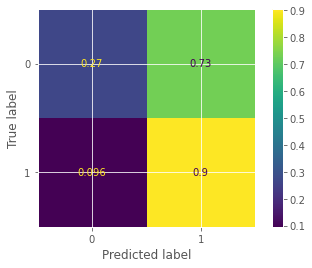

In [267]:
plot_confusion_matrix(best_log, X_test, y_test, normalize = 'true')
plt.show()

In [34]:
best_rf.score(X_test, y_test)

0.64416

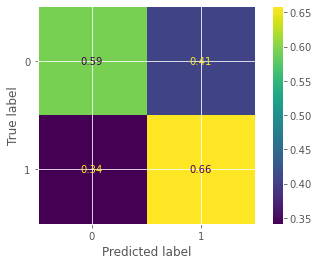

In [266]:
plot_confusion_matrix(best_rf, X_test, y_test, normalize = 'true')
plt.show()

In [35]:
best_gb.score(X_test, y_test)

0.6864

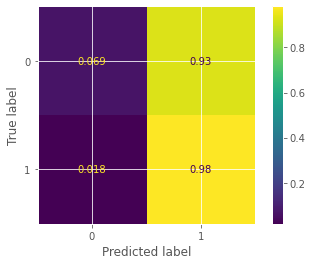

In [265]:
plot_confusion_matrix(best_gb, X_test, y_test, normalize = 'true')
plt.show()

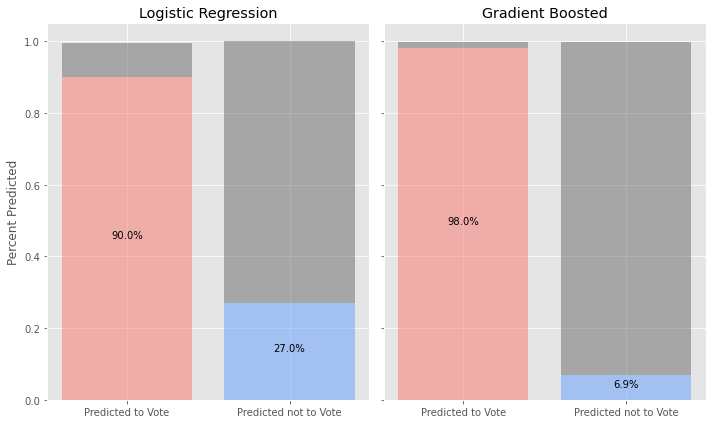

In [58]:
# labels = ['Logistic Regression', 'Random Forrest', 'Gradient Boosted']
tp = .9 
fp = .73
tn = .27
fn = .096

tp2 = .98
fp2 = .93
tn2 = .069
fn2 = .018

# x = np.arange(len(labels))  # the label locations
# width = 0.18  # the width of the bars

fig, axs = plt.subplots(ncols = 2, sharey=True, figsize=(10,6))
# rects1 = ax.bar(x - 1.5*width, tp, width, color='#15B01A', label='Correctly Predicted to Vote')
# rects2 = ax.bar(x - width/2, fp, width, color='#F97306', label='Incorrectly Predicted to Vote')
# rects3 = ax.bar(x + width/2, tn, width, color='#0343DF', label='Correctly Predicted to Would not Vote')
# rects4 = ax.bar(x + 1.5*width, fn, width, color='#E50000', label='Incorrectly Predicted to Would not Vote')

axs[0].bar(x='Predicted to Vote', height=tp, color='#F8766D', alpha = 0.5, label='Correctly Predicted to Vote')
axs[0].bar(x='Predicted to Vote', height=fn, color='#696969', alpha = 0.5, bottom=tp)
axs[0].bar(x='Predicted not to Vote', height=tn, color='#619CFF', alpha = 0.5, label='Correctly Predicted to Would not Vote')
axs[0].bar(x='Predicted not to Vote', height=fp, color='#696969', alpha = 0.5, bottom=tn, label= 'Incorrect Predictions')

axs[1].bar(x='Predicted to Vote', height=tp2, color='#F8766D', alpha = 0.5, label='Correctly Predicted to Vote')
axs[1].bar(x='Predicted to Vote', height=fn2, color='#696969', alpha = 0.5,  bottom=tp2)
axs[1].bar(x='Predicted not to Vote', height=tn2, color='#619CFF', alpha = 0.5,  label='Correctly Predicted Would not Vote')
axs[1].bar(x='Predicted not to Vote', height=fp2, color='#696969', alpha = 0.5,  bottom=tn2, label= 'Incorrect Predictions')

axs[0].text(x='Predicted to Vote', y=tp/2, s=str(f"{tp:.1%}"), ha='center')
axs[0].text(x='Predicted not to Vote', y=tn/2, s=str(f"{tn:.1%}"), ha='center')

axs[1].text(x='Predicted to Vote', y=tp2/2, s=str(f"{tp2:.1%}"), ha='center')
axs[1].text(x='Predicted not to Vote', y=tn2/2, s=str(f"{tn2:.1%}"), ha='center')


# Add some text for labels, title and custom x-axis tick labels, etc.
axs[0].set_ylabel('Percent Predicted')
axs[0].set_title('Logistic Regression')
axs[1].set_title('Gradient Boosted')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
ax.legend(loc='best')

fig.tight_layout()
plt.savefig("../images/confusion_bar.png", transparent= True, dpi=200)

plt.show()

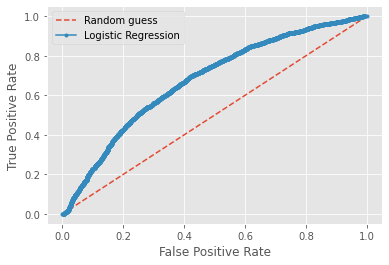

In [37]:
# predict probabilities
yhat = best_log.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random guess')
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.savefig("../images/best_log_roc_curve.png", dpi=200)
plt.show()

In [38]:
print(classification_report(y_test, best_log.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.27      0.38      2218
           1       0.69      0.91      0.79      4032

    accuracy                           0.68      6250
   macro avg       0.65      0.59      0.58      6250
weighted avg       0.66      0.68      0.64      6250



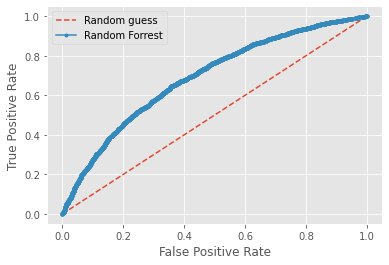

In [39]:
# predict probabilities
yhat = best_rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random guess')
plt.plot(fpr, tpr, marker='.', label='Random Forrest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.savefig("../images/best_rf_roc_curve.png", dpi=200)
plt.show()

In [40]:
print(classification_report(y_test, best_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.64      0.56      2218
           1       0.76      0.65      0.70      4032

    accuracy                           0.64      6250
   macro avg       0.63      0.64      0.63      6250
weighted avg       0.67      0.64      0.65      6250



In [11]:
X_train.columns.tolist()

['AI',
 'AP',
 'BH',
 'HP',
 'OT',
 'U',
 'WH',
 'F',
 'M',
 'O',
 'cd_1',
 'cd_2',
 'cd_3',
 'cd_4',
 'cd_5',
 'cd_6',
 'cd_7',
 'cd_8',
 'cd_9',
 'cd_10',
 'cd_11',
 'cd_12',
 'cd_13',
 'cd_14',
 'cd_99999',
 'age',
 'rural',
 'urban',
 'military']

Feature ranking:
1. feature 25 (0.621559)
2. feature 6 (0.143443)
3. feature 8 (0.036803)
4. feature 7 (0.032594)
5. feature 5 (0.018194)
6. feature 14 (0.017682)
7. feature 15 (0.016098)
8. feature 2 (0.012856)
9. feature 26 (0.010138)
10. feature 10 (0.008683)
11. feature 27 (0.008656)
12. feature 16 (0.007640)
13. feature 23 (0.006494)
14. feature 19 (0.006406)
15. feature 1 (0.006095)
16. feature 20 (0.005554)
17. feature 22 (0.005158)
18. feature 11 (0.004520)
19. feature 18 (0.004291)
20. feature 28 (0.004068)
21. feature 17 (0.003997)
22. feature 13 (0.003940)
23. feature 21 (0.003858)
24. feature 12 (0.003601)
25. feature 3 (0.002855)
26. feature 4 (0.002472)
27. feature 24 (0.001097)
28. feature 0 (0.000684)
29. feature 9 (0.000562)


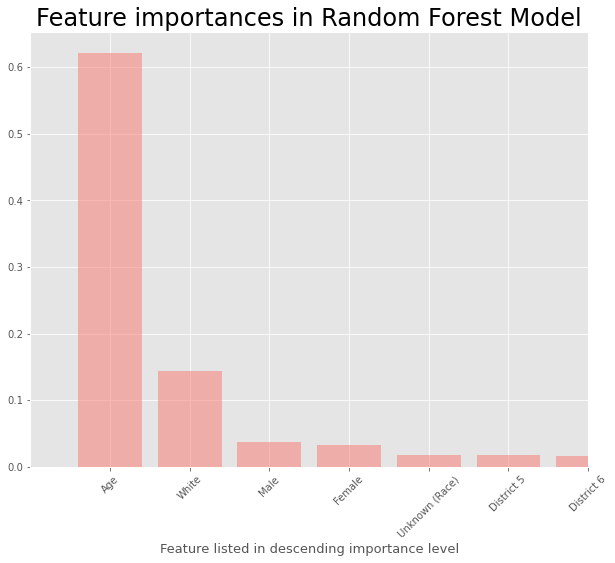

In [17]:
importances = best_rf.feature_importances_
std = np.std([best_rf.feature_importances_ for tree in best_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = ['AI',
 'AP',
 'Black/Hispanic',
 'Hispanic',
 'OT',
 'Unknown (Race)',
 'White',
 'Female',
 'Male',
 'O',
 'District 1',
 'cd_2',
 'cd_3',
 'cd_4',
 'District 5',
 'District 6',
 'District 7',
 'cd_8',
 'cd_9',
 'cd_10',
 'cd_11',
 'cd_12',
 'cd_13',
 'cd_14',
 'Unknown District',
 'Age',
 'rural',
 'urban',
 'military']

# [, '', '', '', '' ]
labels = []
for val in indices:
    labels.append(names[val])
# labels = X_train.columns.tolist()[:-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest

plt.figure(figsize = (10,8))
plt.title("Feature importances in Random Forest Model", fontsize = 24)
plt.bar(range(X_train.shape[1]), importances[indices],
        color='#F8766D', alpha = 0.5, yerr=std[indices], align="center")
#plt.xticks(range(X_train.shape[1]), indices)
plt.xticks(range(X_train.shape[1]), labels, rotation=45)
plt.xlim([-1, 6])
plt.xlabel("Feature listed in descending importance level", fontsize = 13)
plt.savefig("../images/rf_feature_importance.png", dpi=200, transparent = 'true')
plt.show()

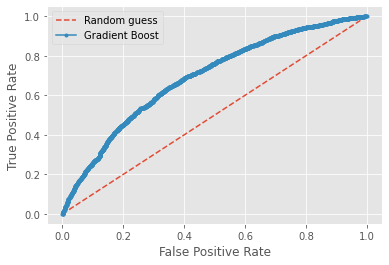

In [43]:
# predict probabilities
yhat = best_gb.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random guess')
plt.plot(fpr, tpr, marker='.', label='Gradient Boost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.savefig("../images/best_gb_roc_curve.png", dpi=200, transparent = 'true')
plt.show()


In [44]:
print(classification_report(y_test, best_gb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      0.31      0.41      2218
           1       0.70      0.90      0.79      4032

    accuracy                           0.69      6250
   macro avg       0.66      0.60      0.60      6250
weighted avg       0.67      0.69      0.65      6250



Feature ranking:
1. feature 25 (0.598888)
2. feature 6 (0.124551)
3. feature 5 (0.052699)
4. feature 7 (0.036387)
5. feature 2 (0.032779)
6. feature 8 (0.027257)
7. feature 14 (0.019660)
8. feature 15 (0.016065)
9. feature 24 (0.011022)
10. feature 3 (0.010365)
11. feature 16 (0.007944)
12. feature 10 (0.007213)
13. feature 27 (0.005687)
14. feature 20 (0.005671)
15. feature 28 (0.005221)
16. feature 11 (0.005122)
17. feature 19 (0.004369)
18. feature 26 (0.004100)
19. feature 1 (0.003975)
20. feature 21 (0.003778)
21. feature 23 (0.002545)
22. feature 13 (0.002475)
23. feature 4 (0.002462)
24. feature 17 (0.002155)
25. feature 9 (0.001962)
26. feature 18 (0.001716)
27. feature 0 (0.001358)
28. feature 22 (0.001352)
29. feature 12 (0.001224)


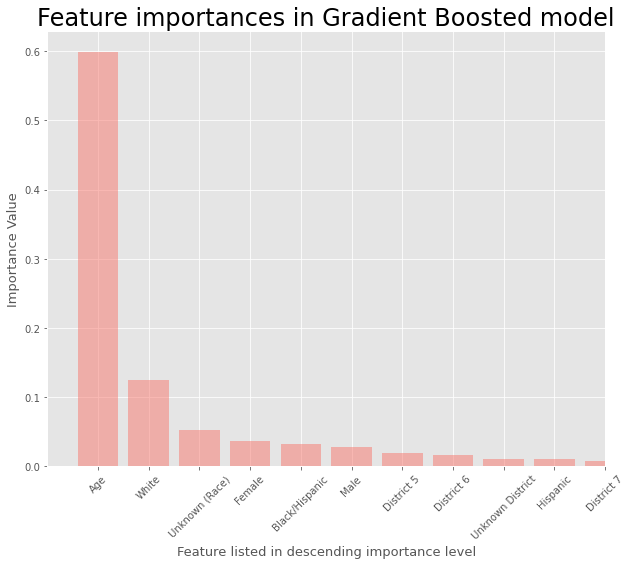

In [18]:
importances = best_gb.feature_importances_
std = np.std([best_gb.feature_importances_ for tree in best_gb.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = ['AI',
 'AP',
 'Black/Hispanic',
 'Hispanic',
 'OT',
 'Unknown (Race)',
 'White',
 'Female',
 'Male',
 'O',
 'District 1',
 'cd_2',
 'cd_3',
 'cd_4',
 'District 5',
 'District 6',
 'District 7',
 'cd_8',
 'cd_9',
 'cd_10',
 'cd_11',
 'cd_12',
 'cd_13',
 'cd_14',
 'Unknown District',
 'Age',
 'rural',
 'urban',
 'military']
labels = []
for val in indices:
    labels.append(names[val])

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure(figsize = (10,8))
plt.title("Feature importances in Gradient Boosted model", fontsize = 24)
plt.bar(range(X_train.shape[1]), importances[indices],
        color='#F8766D', alpha = 0.5, yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), labels, rotation = 45)
plt.xlim([-1, 10])
plt.xlabel("Feature listed in descending importance level", fontsize = 13)
plt.ylabel("Importance Value", fontsize = 13)
plt.savefig("../images/gb_feature_importance.png", dpi=200, transparent = 'true')
plt.show()